# Predicting Short-Term Returns in Cryptocurrency Markets A Machine Learning Approach

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pandas_datareader as dt  # it is for online site data cache like tiingo,ticker
import yfinance as yf
import os
import joblib
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             confusion_matrix, classification_report)

In [2]:
df = pd.read_csv('BTC-USD.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.shape

(3520, 7)

In [5]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3520 entries, 0 to 3519
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3520 non-null   object 
 1   Open       3520 non-null   float64
 2   High       3520 non-null   float64
 3   Low        3520 non-null   float64
 4   Close      3520 non-null   float64
 5   Adj Close  3520 non-null   float64
 6   Volume     3520 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 192.6+ KB


In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3515,2024-05-02,58253.703125,59602.296875,56937.203125,59123.433594,59123.433594,32711813559
3516,2024-05-03,59122.300781,63320.503906,58848.312500,62889.835938,62889.835938,33172023048
3517,2024-05-04,62891.031250,64494.957031,62599.351563,63891.472656,63891.472656,20620477992
3518,2024-05-05,63892.453125,64610.890625,62955.304688,64031.132813,64031.132813,18296164805


In [9]:
# Extract the 'Adj_Close' column as the target series
series = df['Adj Close']

In [10]:
series

0         457.334015
1         424.440002
2         394.795990
3         408.903992
4         398.821014
            ...     
3515    59123.433594
3516    62889.835938
3517    63891.472656
3518    64031.132813
3519    64601.843750
Name: Adj Close, Length: 3520, dtype: float64

In [11]:
# Define the ARIMA model
model = ARIMA(series, order=(5, 1, 0))  # You may need to adjust the order

In [12]:
# Fit the model
model_fit = model.fit()

In [13]:
# Forecast future values
def forecast_future(date, steps):
    future_date = pd.to_datetime(date)
    forecast = model_fit.forecast(steps=steps)
    
    # Print forecasted values
    print(f"Forecasted values for {steps} steps from {series.index[-1]}:")
    forecast_values = forecast
    for i, value in enumerate(forecast_values, start=1):
        future_date += pd.DateOffset(days=1)  # Adjust if forecast steps are not in days
        print(f"{future_date.date()}: {value:.2f}")

In [14]:
# Example usage
forecast_date = '2024-05-15'  # Replace with the desired future date
forecast_steps = 10  # Number of future steps to forecast
forecast_future(forecast_date, forecast_steps)

Forecasted values for 10 steps from 3519:
2024-05-16: 64767.47
2024-05-17: 64829.47
2024-05-18: 64857.98
2024-05-19: 64886.61
2024-05-20: 64897.26
2024-05-21: 64901.34
2024-05-22: 64903.68
2024-05-23: 64905.27
2024-05-24: 64905.93
2024-05-25: 64906.22


In [15]:
df=df.drop(['Date','Adj Close'],axis=1)
df.head()

,Open,High,Low,Close,Volume
0,465.864014,468.174011,452.421997,457.334015,21056800
1,456.859985,456.859985,413.104004,424.440002,34483200
2,424.102997,427.834991,384.532013,394.795990,37919700
3,394.673004,423.295990,389.882996,408.903992,36863600
4,408.084991,412.425995,393.181000,398.821014,26580100


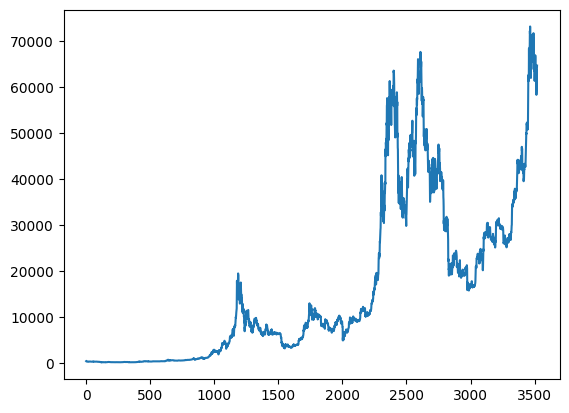

In [16]:
# we are working for Closing Stock
plt.plot(df.Close)
plt.show()

In [17]:
# finding 100 moving average 
ma100=df.Close.rolling(100).mean()
ma100

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
3515    59738.113985
3516    59966.241602
3517    60205.818242
3518    60427.960860
3519    60652.778750
Name: Close, Length: 3520, dtype: float64

In [18]:
# finding 200 moving average 
ma200=df.Close.rolling(200).mean()
ma20

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
3515    49486.425078
3516    49658.276924
3517    49835.655547
3518    50014.169502
3519    50193.579688
Name: Close, Length: 3520, dtype: float64

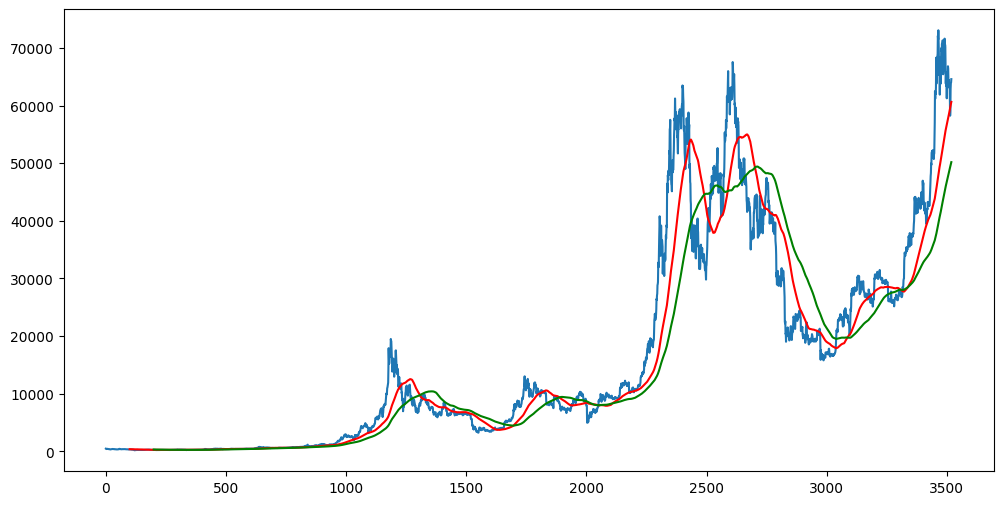

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100,'red')
plt.plot(ma200,'g')
plt.show()

In [20]:
df.shape

(3520, 5)

In [21]:
# splitting data into training and testing

df_train= pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
df_test = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

print(df_train.shape)
print(df_test.shape)

(2464, 1)
(1056, 1)


In [22]:
df_train.head()

,Close
0,457.334015
1,424.440002
2,394.795990
3,408.903992
4,398.821014


In [23]:
df_test.head()

,Close
2464,38347.062500
2465,38053.503906
2466,35787.246094
2467,35615.871094
2468,35698.296875


In [24]:
# Scale down the data
from sklearn.preprocessing import MinMaxScaler       # import lib
scaler = MinMaxScaler(feature_range=(0,1))         # call function

In [25]:
df_train_arr= scaler.fit_transform(df_train)
df_train_arr

array([[0.00440947],
       [0.00389002],
       [0.0034219 ],
       ...,
       [0.6145999 ],
       [0.63229609],
       [0.63526161]])

In [26]:
x_train = []
y_train = []

for i in range(100,df_train_arr.shape[0]):        # df_train_arr[101:1]   # here we take only from df_train
    x_train.append(df_train_arr[i-100: i])
    y_train.append(df_train_arr[i,0])
    
x_train

[array([[0.00440947],
        [0.00389002],
        [0.0034219 ],
        [0.00364469],
        [0.00348546],
        [0.00353806],
        [0.00406927],
        [0.00387052],
        [0.00368685],
        [0.00357396],
        [0.0034965 ],
        [0.00314373],
        [0.00311667],
        [0.00329791],
        [0.00324534],
        [0.00311043],
        [0.00286471],
        [0.00238077],
        [0.00224882],
        [0.00239992],
        [0.00249638],
        [0.00276093],
        [0.00295179],
        [0.00289709],
        [0.00290872],
        [0.00316534],
        [0.0033527 ],
        [0.00351782],
        [0.00342154],
        [0.00322861],
        [0.00324759],
        [0.00336893],
        [0.00333899],
        [0.00323318],
        [0.0032905 ],
        [0.00323812],
        [0.00284742],
        [0.00284628],
        [0.00267141],
        [0.00278879],
        [0.00276171],
        [0.0028348 ],
        [0.00248697],
        [0.00264036],
        [0.00253008],
        [0

In [27]:
 # these 100 days values add to testing dataset for finding moving average    and in the
past_100_days = df_train.tail(100)
past_100_days

,Close
2364,52246.523438
2365,54824.117188
2366,56008.550781
2367,57805.121094
2368,57332.089844
...,...
2459,37334.398438
2460,35552.515625
2461,39097.859375
2462,40218.476563


In [28]:
final_df_test = past_100_days.append(df_test,ignore_index=True)
final_df_test


,Close
0,52246.523438
1,54824.117188
2,56008.550781
3,57805.121094
4,57332.089844
...,...
1151,59123.433594
1152,62889.835938
1153,63891.472656
1154,64031.132813


In [29]:
 final_df_test = past_100_days.append(df_test,ignore_index=True)

In [30]:
print(df_test.shape)
print(df_train.shape)
print(final_df_test.shape)      # 100 days add in this

(1056, 1)
(2464, 1)
(1156, 1)


## Scaling down 

In [31]:
input_data= scaler.fit_transform(final_df_test)
print(input_data)
input_data.shape       # 951+100

[[0.63632892]
 [0.68131608]
 [0.70198819]
 ...
 [0.83957008]
 [0.84200759]
 [0.8519683 ]]


(1156, 1)

In [32]:
x_test =[]
y_test= []

for i in range(100,input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i,0])
print(input_data.shape[0])

1156


In [33]:
x_train,y_train = np.array(x_train),np.array(y_train)
print(np.array(x_train))

[[[0.00440947]
  [0.00389002]
  [0.0034219 ]
  ...
  [0.00247087]
  [0.00228078]
  [0.0022251 ]]

 [[0.00389002]
  [0.0034219 ]
  [0.00364469]
  ...
  [0.00228078]
  [0.0022251 ]
  [0.00236589]]

 [[0.0034219 ]
  [0.00364469]
  [0.00348546]
  ...
  [0.0022251 ]
  [0.00236589]
  [0.00217543]]

 ...

 [[0.76982123]
  [0.76958559]
  [0.80581608]
  ...
  [0.57677521]
  [0.58675227]
  [0.55861374]]

 [[0.76958559]
  [0.80581608]
  [0.82223655]
  ...
  [0.58675227]
  [0.55861374]
  [0.6145999 ]]

 [[0.80581608]
  [0.82223655]
  [0.86294052]
  ...
  [0.55861374]
  [0.6145999 ]
  [0.63229609]]]


In [34]:
x_test,y_test = np.array(x_test),np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(1056, 100, 1)
(1056,)


In [35]:
x_train.shape[1]

100

## ML Model

In [36]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [37]:
model = Sequential()
model.add(LSTM(units =50,activation='relu',return_sequences=True,
               input_shape=(x_train.shape[1],1)))                      # working on 1 column last one(close column) 
model.add(Dropout(0.2))

#2nd layer
model.add(LSTM(units =60,activation='relu',return_sequences=True))                     
model.add(Dropout(0.3))

# third layer
model.add(LSTM(units =80,activation='relu',return_sequences=True))                     
model.add(Dropout(0.4))

# last layer
model.add(LSTM(units =120,activation='relu'))                     
model.add(Dropout(0.5))

# DENSE LAYER
model.add(Dense(units=1))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 60)           26640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 60)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 80)           45120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 120)              

In [39]:
# Define file path for the model
model_path = 'model/keras_model.pkl'

# Define model architecture
def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    return model

# Function to calculate metrics
def calculate_metrics(model_name, predictions, true_values):
    # Implement your metrics calculation here
    # For example, you can calculate mean squared error, accuracy, etc.
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(true_values, predictions)
    print(f"{model_name} - Mean Squared Error: {mse}")

# Check if the model exists
if os.path.exists(model_path):
    # Load the existing model
    model = joblib.load(model_path)
    print("Model loaded successfully.")
else:
    # Create a new model
    model = create_model()
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    # Save the model
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(model, model_path)
    print("Model saved successfully.")

# Make predictions
predictions = model.predict(x_test)

# Calculate and print metrics
calculate_metrics("Keras LSTM Model", predictions, y_test)

Model loaded successfully.
Keras LSTM Model - Mean Squared Error: 0.0010567129554030644


In [40]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [41]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [42]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

26074.041229176677

In [43]:
math.sqrt(mean_squared_error(y_test,test_predict))

39555.91108778907

## Test

In [44]:
df_test

,Close
2464,38347.062500
2465,38053.503906
2466,35787.246094
2467,35615.871094
2468,35698.296875
...,...
3515,59123.433594
3516,62889.835938
3517,63891.472656
3518,64031.132813


In [45]:
 # these 100 days values add to testing dataset for finding moving average    and in the
past_100_days = df_train.tail(100)
past_100_days

,Close
2364,52246.523438
2365,54824.117188
2366,56008.550781
2367,57805.121094
2368,57332.089844
...,...
2459,37334.398438
2460,35552.515625
2461,39097.859375
2462,40218.476563


In [46]:
final_df_test = past_100_days.append(df_test,ignore_index=True)
final_df_test

# now this is final df for testing ( with 100 days training data + testing dataset )

,Close
0,52246.523438
1,54824.117188
2,56008.550781
3,57805.121094
4,57332.089844
...,...
1151,59123.433594
1152,62889.835938
1153,63891.472656
1154,64031.132813


In [47]:
 final_df_test = past_100_days.append(df_test,ignore_index=True)

In [48]:
print(df_test.shape)
print(df_train.shape)
print(final_df_test.shape)      # 100 days add in this

(1056, 1)
(2464, 1)
(1156, 1)


In [49]:
# Making Prediction 
y_predicted = model.predict(x_test)

In [50]:
# making x_train predict and comapring both
x_train_pred=model.predict(x_train)

In [51]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,x_train_pred))

0.01657696894498364

In [52]:
math.sqrt(mean_squared_error(y_test,y_predicted))

0.03250712161054965

In [53]:
y_predicted.shape


(1056, 1)

In [54]:
y_test

array([0.39373941, 0.38861589, 0.34906253, ..., 0.83957008, 0.84200759,
       0.8519683 ])

In [55]:
y_predicted

array([[0.45750672],
       [0.44052356],
       [0.42258435],
       ...,
       [0.8422039 ],
       [0.8815073 ],
       [0.8862657 ]], dtype=float32)

In [56]:
print(y_test.shape)
print(x_test.shape)    

(1056,)
(1056, 100, 1)


## Scaling Up

In [57]:
scaler.scale_

array([1.74531596e-05])

In [58]:
scale_factor= 1/scaler.scale_
y_predicted = y_predicted * scale_factor
y_test= y_test* scale_factor

In [59]:
y_predicted = pd.DataFrame(y_predicted)
y_predicted

,0
0,26213.403553
1,25240.333243
2,24212.484399
3,22431.642446
4,21371.561694
...,...
1051,44628.396313
1052,44663.537904
1053,48255.097285
1054,50507.031218


In [60]:
y_test = pd.DataFrame(y_test)

In [61]:
y_test

,0
0,22559.778320
1,22266.219726
2,19999.961914
3,19828.586914
4,19911.012695
...,...
1051,43336.149414
1052,47102.551758
1053,48104.188476
1054,48243.848633


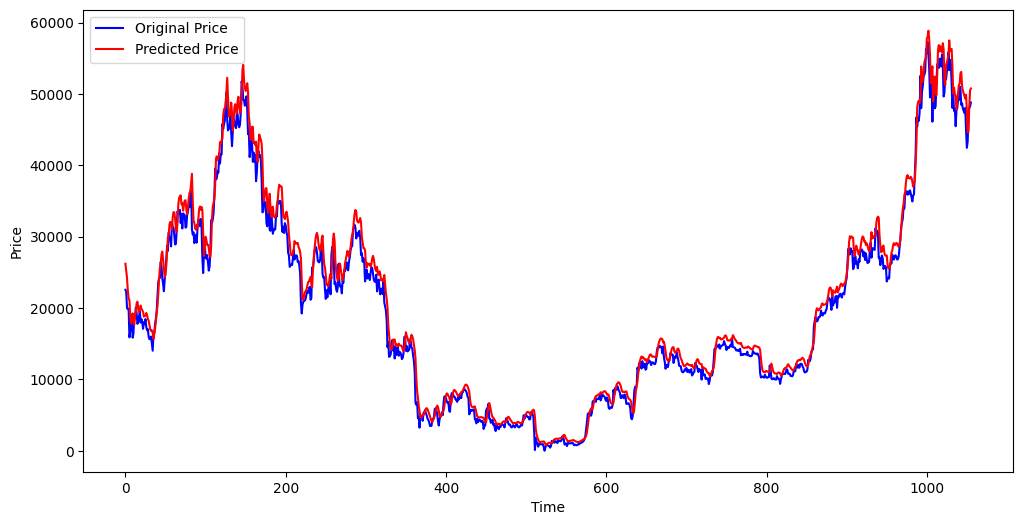

In [62]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b',label = 'Original Price')
plt.plot(y_predicted,'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()